In [318]:
# Yahoo Finance Data Acquisition of Required Data
#Target Period: 2006-01-01 to 2025-06-30

#Imports
#Import Yahoo Finance data library for data acquisition
import pandas as pd
import numpy as np
import yfinance as yf

In [320]:
#Define instruments and Date range
start = "2006-01-01"
end = "2025-06-30"

# S&P500 ETF (proxy)
df_spx_raw = yf.download("SPY", start=start, end=end)

# Dollar Index (Yahoo ticker: DX-Y.NYB)
df_dxy = yf.download("DX-Y.NYB", start=start, end=end)

# WTI Oil Futures (Yahoo ticker: CL=F)
df_wti = yf.download("CL=F", start=start, end=end)

print(df_spx_raw.head())
print(df_dxy.head())
print(df_wti.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open    Volume
Ticker            SPY        SPY        SPY        SPY       SPY
Date                                                            
2006-01-03  87.721733  87.929443  86.122388  86.676277  73256700
2006-01-04  88.137123  88.268667  87.721704  87.832484  51899600
2006-01-05  88.192528  88.337922  87.846349  88.033288  47307500
2006-01-06  88.926430  89.023359  88.178682  88.635641  62885900
2006-01-09  89.154861  89.355640  88.884842  88.912532  43527400
Price           Close       High        Low       Open   Volume
Ticker       DX-Y.NYB   DX-Y.NYB   DX-Y.NYB   DX-Y.NYB DX-Y.NYB
Date                                                           
2006-01-03  89.839996  90.940002  89.779999  90.750000        0
2006-01-04  89.139999  89.860001  89.010002  89.730003        0
2006-01-05  89.330002  89.629997  89.180000  89.269997        0
2006-01-06  88.849998  89.629997  88.800003  89.349998        0
2006-01-09  89.250000  89.449997

# Data Preprocessing & Transformation

In [323]:
#Import required libraries
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

#Load and confirm the raw datasets
print("SPY shape:", df_spx_raw.shape)
print("DXY shape:", df_dxy.shape)
print("WTI shape:", df_wti.shape)

#Standardise column names and isolate 'Close' column
df_spx = df_spx_raw[['Close']].rename(columns={'Close': 'SPY_Close'})
df_dxy = df_dxy[['Close']].rename(columns={'Close': 'DXY_Close'})
df_wti = df_wti[['Close']].rename(columns={'Close': 'WTI_Close'})

#Merge and clean datasets
df = df_spx.join([df_dxy, df_wti], how='inner')
df = df.dropna()
print("Merged dataframe shape:", df.shape)

#Compute returns and changes
df['SPY_log_ret'] = np.log(df['SPY_Close'] / df['SPY_Close'].shift(1)) * 100
df['SPY_price_change'] = df['SPY_Close'].diff()
df['SPY_p_change'] = df['SPY_Close'].pct_change() * 100

df['DXY_ret'] = np.log(df['DXY_Close'] / df['DXY_Close'].shift(1)) * 100
df['WTI_ret'] = np.log(df['WTI_Close'] / df['WTI_Close'].shift(1)) * 100

df = df.dropna()

SPY shape: (4902, 5)
DXY shape: (4905, 5)
WTI shape: (4901, 5)
Merged dataframe shape: (4898, 3)


# Time Series Splitting & Validation

# Static Chronological Split

In [327]:
# ================================================================
# 3.2A STATIC CHRONOLOGICAL SPLIT
# ================================================================

# Function for chronological splitting of time series data
def chronological_split(df, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    """
    Chronologically splits the dataset into train, validation, and test sets.
    Ensures no look-ahead bias by using the time order of observations.

    Parameters:
    - df: pandas DataFrame with DateTime index
    - train_ratio: float, proportion of training data
    - val_ratio: float, proportion of validation data
    - test_ratio: float, proportion of testing data

    Returns:
    - train_df, val_df, test_df
    """
    # Validate ratios
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9, "Ratios must sum to 1."

    n = len(df)
    i_train_end = int(n * train_ratio)
    i_val_end = int(n * (train_ratio + val_ratio))

    train_df = df.iloc[:i_train_end].copy()
    val_df = df.iloc[i_train_end:i_val_end].copy()
    test_df = df.iloc[i_val_end:].copy()

    print(f"Total samples: {n}")
    print(f"Train: {len(train_df)} ({len(train_df)/n:.1%}), "
          f"Validation: {len(val_df)} ({len(val_df)/n:.1%}), "
          f"Test: {len(test_df)} ({len(test_df)/n:.1%})")

    return train_df, val_df, test_df


# ---------------------------------------------------------------
# Apply chronological split to your processed dataframe
# ---------------------------------------------------------------
train_df, val_df, test_df = chronological_split(df, 0.8, 0.1, 0.1)

# Confirm the split visually
print("\nTrain range:", train_df.index.min(), "→", train_df.index.max())
print("Validation range:", val_df.index.min(), "→", val_df.index.max())
print("Test range:", test_df.index.min(), "→", test_df.index.max())

# Display sample data from each set
print("\nSample from training data:")
print(train_df.tail())

print("\nSample from validation data:")
print(val_df.head())

print("\nSample from test data:")
print(test_df.head())

Total samples: 4895
Train: 3916 (80.0%), Validation: 489 (10.0%), Test: 490 (10.0%)

Train range: 2006-01-04 00:00:00 → 2021-08-03 00:00:00
Validation range: 2021-08-04 00:00:00 → 2023-07-14 00:00:00
Test range: 2023-07-17 00:00:00 → 2025-06-27 00:00:00

Sample from training data:
Price        SPY_Close  DXY_Close  WTI_Close SPY_log_ret SPY_price_change  \
Ticker             SPY   DX-Y.NYB       CL=F                                
Date                                                                        
2021-07-28  413.541992  92.320000  72.389999   -0.041015        -0.169647   
2021-07-29  415.257080  91.860001  73.620003    0.413874         1.715088   
2021-07-30  413.240479  92.169998  73.949997   -0.486810        -2.016602   
2021-08-02  412.373413  92.050003  71.260002   -0.210041        -0.867065   
2021-08-03  415.728302  92.080002  70.559998    0.810265         3.354889   

Price      SPY_p_change   DXY_ret   WTI_ret  
Ticker                                       
Date     

Create functions: AWT and Indicators, scaling and rolling windows

# Rolling Window (Walk-Forward Validation) and Adaptive Wavelength Transform (AWT)

# Flatten multi-index columns and apply wavelet denoising helper

In [332]:
# ================================================================
# ✅ FIXED: Walk-Forward Validation with AWT Features + Scaling
# ================================================================
import pywt
import ta
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ================================================================
# 1️⃣  Utility: Flatten MultiIndex columns
# ================================================================
def flatten_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure single-level, clean column names."""
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [
            '_'.join([str(c) for c in tup if c is not None]).strip()
            for tup in df.columns
        ]
    else:
        df.columns = [str(c).strip() for c in df.columns]
    # Remove duplicates if flattening causes any
    df = df.loc[:, ~pd.Index(df.columns).duplicated()]
    return df


# ================================================================
# 2️⃣  Wavelet Denoising Helper
# ================================================================
def wavelet_denoise_series(x: pd.Series,
                           wavelet: str = "db2",
                           level: int = 2,
                           mode: str = "soft") -> pd.DataFrame:
    """
    Simple wavelet decompose + denoise returning smooth & detail as DataFrame.
    """
    x = pd.Series(x).astype(float)

    # Wavelet decomposition
    coeffs = pywt.wavedec(x.values, wavelet=wavelet, level=level)
    
    # Universal threshold based on noise estimation
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745 if len(coeffs[-1]) else 0.0
    thr = sigma * np.sqrt(2 * np.log(len(x)))

    # Threshold all detail coefficients (keep cA intact)
    coeffs_thr = [coeffs[0]] + [pywt.threshold(c, thr, mode=mode) for c in coeffs[1:]]

    #Reconstruct smoothed and detailed components
    x_s = pywt.waverec(coeffs_thr, wavelet)[:len(x)]  # smoothed component
    x_d = x.values[:len(x_s)] - x_s  # detail component
    return pd.DataFrame({"SPY_s": x_s, "SPY_d": x_d}, index=x.index)


# Build AWT features and 21 financial indicators

In [335]:
def compute_awt_features(df_slice: pd.DataFrame) -> pd.DataFrame:
    """
    Build AWT-based features + 21 indicators safely.
    Requires SPY OHLCV; will create SPY_log_ret if missing.
    Produces:
        SPY_log_ret, SPY_s, SPY_d, 21 indicators, y_1d
    """
    # ---------- helpers ----------
    def _flatten(df):
        # use your existing flatten logic
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = ['_'.join([str(c) for c in tup if c is not None]).strip()
                          for tup in df.columns]
        else:
            df.columns = [str(c).strip() for c in df.columns]
        # drop duplicate columns if flattening made any
        df = df.loc[:, ~pd.Index(df.columns).duplicated()]
        return df

    def _find_col(df, *must_contain):
        must = [m.lower() for m in must_contain]
        for c in df.columns:
            lc = str(c).lower()
            if all(m in lc for m in must):
                return c
        return None

    # --- wavelet helper that never returns all-NaN ---
    def _wavelet_denoise_nonan(x: pd.Series) -> pd.DataFrame:
        """
        Run wavelet denoising on the non-NaN part of x,
        then re-align back to the full index.
        """
        x = pd.Series(x).astype(float)
        mask = x.notna()
        x_clean = x[mask]

        if x_clean.empty:
            # nothing to do – return all NaNs with same index
            return pd.DataFrame(
                {"SPY_s": np.nan, "SPY_d": np.nan},
                index=x.index,
            )

        # use your tested global helper
        s_hat = wavelet_denoise_series(x_clean)   # returns SPY_s, SPY_d

        # reindex to full x index (NaN where x was NaN)
        out = pd.DataFrame(index=x.index, columns=["SPY_s", "SPY_d"], dtype=float)
        out.loc[mask, "SPY_s"] = s_hat["SPY_s"].values
        out.loc[mask, "SPY_d"] = s_hat["SPY_d"].values
        return out

    # ---------- start main logic ----------
    df_f = _flatten(df_slice.copy())

    # locate OHLCV (best effort)
    c_open   = _find_col(df_f, 'spy', 'open')
    c_high   = _find_col(df_f, 'spy', 'high')
    c_low    = _find_col(df_f, 'spy', 'low')
    c_close  = _find_col(df_f, 'spy', 'close')
    c_volume = _find_col(df_f, 'spy', 'volume')

    # ---- ensure log returns (needed for AWT) ----
    if 'SPY_log_ret' not in df_f.columns:
        if c_close is None:
            raise KeyError("compute_awt_features() needs SPY close prices to derive SPY_log_ret.")
        df_f['SPY_log_ret'] = np.log(df_f[c_close] / df_f[c_close].shift(1)) * 100

    # ---- AWT on SPY_log_ret -> SPY_s (smooth), SPY_d (detail) ----
    s_hat = _wavelet_denoise_nonan(df_f['SPY_log_ret'])
    df_f = df_f.join(s_hat, how='left')

    # ---- choose price series for indicators (prefer denoised) ----
    price = df_f['SPY_s'].fillna(df_f['SPY_log_ret'])

    # --------------- 21 INDICATORS ----------------
    # 1–3: moving averages
    df_f['EMA20'] = ta.trend.EMAIndicator(close=price, window=20).ema_indicator()
    df_f['MA5']   = ta.trend.SMAIndicator(close=price, window=5).sma_indicator()
    df_f['MA10']  = ta.trend.SMAIndicator(close=price, window=10).sma_indicator()

    # 4 MACD
    df_f['MACD'] = ta.trend.MACD(close=price).macd()

    # 5 ROC(10)
    df_f['ROC'] = ta.momentum.ROCIndicator(close=price, window=10).roc()

    # 6–7 momentum (6m, 12m) – these will naturally have more NaNs at the start
    df_f['MTM6']  = price / price.shift(126) - 1
    df_f['MTM12'] = price / price.shift(252) - 1

    # 8 SMI (needs high + low)
    if c_high and c_low:
        stoch = ta.momentum.StochasticOscillator(
            high=df_f[c_high], low=df_f[c_low],
            close=price, window=14, smooth_window=3
        )
        df_f['SMI'] = stoch.stoch_signal()
    else:
        df_f['SMI'] = np.nan

    # 9 ATR(14)
    df_f['ATR'] = ta.volatility.AverageTrueRange(
        high=df_f[c_high] if c_high else price,
        low=df_f[c_low] if c_low else price,
        close=price, window=14
    ).average_true_range()

    # 10–12 Bollinger
    boll = ta.volatility.BollingerBands(close=price, window=20, window_dev=2)
    df_f['BOLL_upper']     = boll.bollinger_hband()
    df_f['BOLL_lower']     = boll.bollinger_lband()
    df_f['BOLL_bandwidth'] = df_f['BOLL_upper'] - df_f['BOLL_lower']

    # 13 CCI(20)
    if c_high and c_low and c_close:
        df_f['CCI'] = ta.trend.CCIIndicator(
            high=df_f[c_high], low=df_f[c_low],
            close=df_f[c_close], window=20
        ).cci()
    else:
        df_f['CCI'] = np.nan

    # 14 WVAD (needs full OHLCV)
    if c_open and c_high and c_low and c_close and c_volume:
        rng = (df_f[c_high] - df_f[c_low]).replace(0, np.nan)
        df_f['WVAD'] = ((df_f[c_close] - df_f[c_open]) / (rng + 1e-10)) * df_f[c_volume]
    else:
        df_f['WVAD'] = np.nan

    # 15 RSI(14)
    df_f['RSI14'] = ta.momentum.RSIIndicator(close=price, window=14).rsi()

    # 16–17 Stochastic %K/%D
    if c_high and c_low:
        st = ta.momentum.StochasticOscillator(
            high=df_f[c_high], low=df_f[c_low],
            close=price, window=14, smooth_window=3
        )
        df_f['STO_K'] = st.stoch()
        df_f['STO_D'] = st.stoch_signal()
    else:
        df_f[['STO_K', 'STO_D']] = np.nan

    # 18 ADX(14)
    if c_high and c_low and c_close:
        df_f['ADX14'] = ta.trend.ADXIndicator(
            high=df_f[c_high], low=df_f[c_low],
            close=df_f[c_close], window=14
        ).adx()
    else:
        df_f['ADX14'] = np.nan

    # 19 OBV
    if c_close and c_volume:
        df_f['OBV'] = ta.volume.OnBalanceVolumeIndicator(
            close=df_f[c_close], volume=df_f[c_volume]
        ).on_balance_volume()
    else:
        df_f['OBV'] = np.nan

    # 20 MFI(14)
    if c_high and c_low and c_close and c_volume:
        df_f['MFI14'] = ta.volume.MFIIndicator(
            high=df_f[c_high], low=df_f[c_low],
            close=df_f[c_close], volume=df_f[c_volume], window=14
        ).money_flow_index()
    else:
        df_f['MFI14'] = np.nan

    # 21 Williams %R(14)
    if c_high and c_low and c_close:
        df_f['WILLR14'] = ta.momentum.WilliamsRIndicator(
            high=df_f[c_high], low=df_f[c_low],
            close=df_f[c_close], lbp=14
        ).williams_r()
    else:
        df_f['WILLR14'] = np.nan

    # ---- target: next-day SPY log return ----
    df_f['y_1d'] = df_f['SPY_log_ret'].shift(-1)

    # ---- final clean: only require target to exist ----
    df_f = df_f[df_f['y_1d'].notna()]

    return df_f

# Add Scaling Helper and Rolling Window Generator

In [338]:
# ================================================================
# 4️⃣  Scaling Helper
# ================================================================
def fit_transform_scale(X_train, X_val=None, X_test=None):
    """
    Fit StandardScaler on training set; transform others with same parameters.
    """
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(X_train)
    Xva = scaler.transform(X_val) if X_val is not None else None
    Xte = scaler.transform(X_test) if X_test is not None else None
    return Xtr, Xva, Xte, scaler


# ================================================================
# 5️⃣  Rolling Window Generator
# ================================================================
def walk_forward_windows(df, train_span, eval_span, step):
    """
    Generator producing chronological (train_df, eval_df) pairs.
    """
    n = len(df)
    start = 0
    while True:
        tr_start = start
        tr_end   = tr_start + train_span
        ev_end   = tr_end + eval_span
        if ev_end > n:
            break
        yield df.iloc[tr_start:tr_end].copy(), df.iloc[tr_end:ev_end].copy()
        start += step


# Implement walk forward validation using pre-defined functions

In [341]:
# ================================================================
# 6️⃣  Walk-Forward Execution Loop
# ================================================================
# --- REPLACE your walk-forward loop with this safer version ---
TRAIN_SPAN = 1500      # ~6 years
EVAL_SPAN  = 60        # ~3 months
STEP       = 20        # ~1 month shift

feature_cols = None
target_col   = 'y_1d'

MIN_TR_ROWS  = 100   # guard: minimum rows required after dropna
MIN_EV_ROWS  = 10

all_preds, all_truth = [], []

made_plots = False  # Track if we’ve already plotted

for w, (df_tr_raw, df_ev_raw) in enumerate(walk_forward_windows(df, TRAIN_SPAN, EVAL_SPAN, STEP), start=1):
    df_tr_raw = flatten_cols(df_tr_raw)
    df_ev_raw = flatten_cols(df_ev_raw)

    # Build features on combined slice
    df_comb       = pd.concat([df_tr_raw, df_ev_raw], axis=0)
    df_feat_comb  = compute_awt_features(df_comb)

    # Split back to train/eval by index, THEN drop NaNs
    tr_end_idx = df_tr_raw.index[-1]
    df_feat_tr = df_feat_comb.loc[:tr_end_idx].dropna()
    df_feat_ev = df_feat_comb.loc[df_ev_raw.index[0]:df_ev_raw.index[-1]].dropna()

    # Window too small? (happens in first windows due to long lookbacks)
    if len(df_feat_tr) < MIN_TR_ROWS or len(df_feat_ev) < MIN_EV_ROWS:
        # optional: print(f"Skipping window {w}: train={len(df_feat_tr)}, eval={len(df_feat_ev)}")
        continue

    # Choose features once (exclude raw returns & targets)
    if feature_cols is None:
        exclude = {'SPY_log_ret', 'DXY_ret', 'WTI_ret'} | {c for c in df_feat_tr.columns if c.startswith('y_')}
        feature_cols = [c for c in df_feat_tr.columns if c not in exclude]

    X_tr = df_feat_tr[feature_cols].values
    y_tr = df_feat_tr[target_col].values
    X_ev = df_feat_ev[feature_cols].values
    y_ev = df_feat_ev[target_col].values

    # Another guard (just in case)
    if X_tr.shape[0] == 0 or X_ev.shape[0] == 0:
        # optional: print(f"Skipping window {w}: empty matrix after selection")
        continue

    # Scale using train stats only
    X_tr_s, _, X_ev_s, scaler = fit_transform_scale(X_tr, None, X_ev)

    # Fit & predict here when ready:
    # model.fit(X_tr_s, y_tr)
    # y_hat = model.predict(X_ev_s)
    # all_preds.append(y_hat); all_truth.append(y_ev)

print("✅ Walk-forward loop ran with NaN-safe slicing and window guards.")


✅ Walk-forward loop ran with NaN-safe slicing and window guards.


# Build and save AWT features

In [343]:
# === Build & save FULL AWT + 21-indicator + exogenous (DXY/WTI) + target dataset ===

import numpy as np
from pathlib import Path

# Where to save
BASE = Path("data/processed")
BASE.mkdir(parents=True, exist_ok=True)

# 1) Core AWT + indicators + target y_1d from raw SPY OHLCV
#    ------------------------------------------------------
# Start from raw Yahoo SPY dataframe with MultiIndex columns: df_spx_raw
df_spy_raw_flat = flatten_cols(df_spx_raw.copy())
print("Flattened SPY columns:", df_spy_raw_flat.columns)

# Ensure SPY_log_ret exists for AWT step
if "SPY_log_ret" not in df_spy_raw_flat.columns:
    df_spy_raw_flat["SPY_log_ret"] = np.log(
        df_spy_raw_flat["Close_SPY"] / df_spy_raw_flat["Close_SPY"].shift(1)
    ) * 100

# Build AWT features + 21 indicators + target y_1d
df_awt_core = compute_awt_features(df_spy_raw_flat)
print("Core AWT shape (SPY only):", df_awt_core.shape)

# Quick sanity check on SPY_s / SPY_d
print("\nNaN rates for key series (core):")
print(df_awt_core[["SPY_log_ret", "SPY_s", "SPY_d"]].isna().mean())

# 2) Exogenous returns (DXY, WTI) from merged & cleaned dataframe `df`
#    -----------------------------------------------------------------
# `df` is the merged "Data Preprocessing & Transformation" dataframe
df_exog = df[["DXY_ret", "WTI_ret"]].copy()

# If for any reason exog has a MultiIndex, flatten its column names
import pandas as pd
if isinstance(df_exog.columns, pd.MultiIndex):
    df_exog.columns = df_exog.columns.get_level_values(0).str.strip()

# Align exogenous series to the AWT core index (Date)
df_exog = df_exog.reindex(df_awt_core.index)

print("\nExog columns:", df_exog.columns)
print("Exog shape (reindexed):", df_exog.shape)

# 3) Merge core AWT block with exogenous, then save
#    ---------------------------------------------
df_awt = df_awt_core.join(df_exog, how="left")
print("\nFinal AWT + exogenous + target shape:", df_awt.shape)

# More sanity checks
print("\nHead of key columns:")
print(df_awt[["SPY_log_ret", "SPY_s", "SPY_d", "DXY_ret", "WTI_ret"]].head())

print("\nNaN rates for SPY_s / SPY_d / DXY / WTI:")
print(df_awt[["SPY_s", "SPY_d", "DXY_ret", "WTI_ret"]].isna().mean())

# 4) Save to disk
out_path = BASE / "df_awt_features.csv"
df_awt.to_csv(out_path)
print("\n✅ Saved AWT + 21 indicators + exogenous + target to:", out_path.resolve())


Flattened SPY columns: Index(['Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY'], dtype='object')
Core AWT shape (SPY only): (4901, 30)

NaN rates for key series (core):
SPY_log_ret    0.000204
SPY_s          0.000204
SPY_d          0.000204
dtype: float64

Exog columns: Index(['DXY_ret', 'WTI_ret'], dtype='object', name='Price')
Exog shape (reindexed): (4901, 2)

Final AWT + exogenous + target shape: (4901, 32)

Head of key columns:
            SPY_log_ret     SPY_s     SPY_d   DXY_ret   WTI_ret
Date                                                           
2006-01-03          NaN       NaN       NaN       NaN       NaN
2006-01-04     0.472414  0.359152  0.113262 -0.782211  0.442477
2006-01-05     0.062842  0.360382 -0.297540  0.212924 -0.998340
2006-01-06     0.828716  0.295122  0.533594 -0.538786  2.236311
2006-01-09     0.256548  0.247678  0.008870  0.449188 -1.111904

NaN rates for SPY_s / SPY_d / DXY / WTI:
SPY_s      0.000204
SPY_d      0.000204
DXY_ret    0.001428
W

In [346]:
df_awt_core[["SPY_log_ret", "SPY_s", "SPY_d"]].head()
df_awt_core[["SPY_s", "SPY_d"]].isna().mean()

SPY_s    0.000204
SPY_d    0.000204
dtype: float64

In [352]:
df_awt.isna().mean().sort_values(ascending=False)

MTM12             0.051622
MTM6              0.025913
MACD              0.005305
BOLL_bandwidth    0.004081
BOLL_lower        0.004081
EMA20             0.004081
BOLL_upper        0.004081
CCI               0.003877
STO_D             0.003061
SMI               0.003061
STO_K             0.002653
RSI14             0.002653
WILLR14           0.002653
MFI14             0.002653
ROC               0.002244
MA10              0.002040
DXY_ret           0.001428
WTI_ret           0.001428
MA5               0.001020
SPY_d             0.000204
SPY_s             0.000204
SPY_log_ret       0.000204
ADX14             0.000000
OBV               0.000000
y_1d              0.000000
Close_SPY         0.000000
WVAD              0.000000
High_SPY          0.000000
Volume_SPY        0.000000
Open_SPY          0.000000
Low_SPY           0.000000
ATR               0.000000
dtype: float64

# Stationarity Tests (ADF & PP)

Stationarity: If ADF/PP p-values < 0.05, treat SPY_log_ret as stationary (set ARIMAX d=0).

Long memory:

R/S (Hurst H): H≈0.5 → short memory; H>0.5 → persistent/long memory; H<0.5 → anti-persistence.

GPH d: 0 ≤ d < 0.5 indicates long memory but stationary, motivating ARFIMA/FI-volatility (e.g., FIGARCH/FIEGARCH).

Next step connection: Use these diagnostics to justify (i) ARIMAX order search with d=0 for returns, and (ii) FIGARCH/EGARCH (or FIEGARCH via R) for volatility with a fractional component if d suggests long memory

In [356]:
# ===============================================================
# Stationarity Tests on SPY_log_ret
# - Augmented Dickey–Fuller (ADF)
# - Phillips–Perron (PP)
# ===============================================================
from arch.unitroot import PhillipsPerron

# ---------- Helper Functions ----------
def run_adf(x: pd.Series, autolag='AIC'):
    x = pd.Series(x).dropna()
    res = adfuller(x, autolag=autolag)
    return {
        'stat': res[0],
        'pvalue': res[1],
        'lags_used': res[2],
        'nobs': res[3],
        'crit': {'1%': res[4]['1%'], '5%': res[4]['5%'], '10%': res[4]['10%']},
    }

def run_pp(x: pd.Series, trend='c'):
    """
    Phillips–Perron unit root test.
    Compatible with arch versions that do not expose .bandwidth.
    """
    x = pd.Series(x).dropna()
    res = PhillipsPerron(x, trend=trend)
    return {
        'stat': res.stat,
        'pvalue': res.pvalue,
        'lags_used': getattr(res, 'lags', None),
        'crit': getattr(res, 'critical_values', {}),
        'summary': res.summary().as_text() if hasattr(res, 'summary') else None
    }

def stationarity_verdict(p):
    return "Reject unit root (stationary)" if p < 0.05 else "Fail to reject unit root (non-stationary)"

# ---------- Run Tests ----------
y_ret = df['SPY_log_ret'].dropna()

adf_res = run_adf(y_ret, autolag='AIC')
pp_res  = run_pp(y_ret, trend='c')

# ---------- Print Results ----------
print("=== Augmented Dickey–Fuller (ADF) on SPY_log_ret ===")
print(f"Test statistic: {adf_res['stat']:.4f} | p-value: {adf_res['pvalue']:.4g} "
      f"| lags: {adf_res['lags_used']} | nobs: {adf_res['nobs']}")
print(f"Critical values: 1%={adf_res['crit']['1%']:.3f}, 5%={adf_res['crit']['5%']:.3f}, 10%={adf_res['crit']['10%']:.3f}")
print("Verdict (ADF):", stationarity_verdict(adf_res['pvalue']))

print("\n=== Phillips–Perron (PP) on SPY_log_ret ===")
print(f"Test statistic: {pp_res['stat']:.4f} | p-value: {pp_res['pvalue']:.4g} | lags: {pp_res['lags_used']}")
print(f"Critical values: { {k: round(v,3) for k,v in pp_res['crit'].items()} }")
print("Verdict (PP): ", stationarity_verdict(pp_res['pvalue']))



=== Augmented Dickey–Fuller (ADF) on SPY_log_ret ===
Test statistic: -17.7352 | p-value: 3.421e-30 | lags: 15 | nobs: 4879
Critical values: 1%=-3.432, 5%=-2.862, 10%=-2.567
Verdict (ADF): Reject unit root (stationary)

=== Phillips–Perron (PP) on SPY_log_ret ===
Test statistic: -78.0260 | p-value: 0 | lags: 32
Critical values: {'1%': -3.432, '5%': -2.862, '10%': -2.567}
Verdict (PP):  Reject unit root (stationary)


# Long- Memory Test (R/S & GPH)

In [359]:
# ===============================================================
# Long-Memory Tests on SPY_log_ret
# - Rescaled Range (R/S) -> Hurst exponent H
# - Geweke–Porter–Hudak (GPH) -> fractional differencing d
# ===============================================================
import numpy as np
import pandas as pd

# ---------- Helper Functions ----------
def hurst_rs(x: pd.Series, min_window=16, max_window=None):
    """
    Classic R/S estimator of Hurst exponent H.
    H ~ 0.5 short memory; H>0.5 persistence; H<0.5 anti-persistence.
    """
    x = pd.Series(x).dropna().values.astype(float)
    n = x.size
    if n < 64:
        raise ValueError("Series too short for R/S estimation.")
    if max_window is None:
        max_window = n // 4
    wins = np.unique(np.floor(np.logspace(np.log10(min_window), np.log10(max_window), num=12)).astype(int))
    RS = []
    for w in wins:
        if w < 8: 
            continue
        blocks = n // w
        if blocks < 2:
            continue
        vals = []
        for b in range(blocks):
            seg = x[b*w:(b+1)*w]
            seg = seg - seg.mean()
            y = np.cumsum(seg)
            R = y.max() - y.min()
            S = seg.std(ddof=1)
            if S > 0:
                vals.append(R / S)
        if len(vals):
            RS.append((w, np.mean(vals)))
    RS = np.array(RS)
    slope = np.polyfit(np.log(RS[:,0]), np.log(RS[:,1]), 1)[0]
    return {'H': slope, 'windows': RS[:,0], 'RS': RS[:,1]}

def gph_fractional_d(x: pd.Series, m=None):
    """
    GPH (log-periodogram) estimator of fractional differencing parameter d.
    Uses the regression: log I(λ_j) ~ a - d * log(4 sin^2(λ_j/2)) + u_j
    => slope ≈ -d, so d_hat = -slope
    """
    x = pd.Series(x).dropna().values.astype(float)
    x = x - x.mean()
    T = len(x)
    if m is None:
        m = int(T**0.5)  # common choice; try T^0.6 for robustness
    j = np.arange(1, m+1)
    lam = 2*np.pi*j/T
    X = np.fft.fft(x)
    I = (1/(2*np.pi*T)) * (np.abs(X[j])**2)
    z = np.log(4*(np.sin(lam/2)**2))
    y = np.log(I)
    b = np.polyfit(z, y, 1)[0]  # slope
    d_hat = -b
    zc = z - z.mean()
    se = np.pi / np.sqrt(6*np.sum(zc**2))  # asymptotic SE (approx)
    ci = (d_hat - 1.96*se, d_hat + 1.96*se)
    return {'d': d_hat, 'se': se, 'ci95': ci, 'm': m, 'T': T}

def d_comment(d):
    if d < 0:
        return "Anti-persistent / over-differenced"
    if 0 <= d < 0.5:
        return "Long memory but covariance-stationary (ARFIMA range)"
    if 0.5 <= d < 1:
        return "Non-stationary long memory (mean-reverting, infinite variance)"
    return "Unit root or stronger non-stationarity"

# ---------- Run Tests ----------
y_ret = df['SPY_log_ret'].dropna()

rs_res  = hurst_rs(y_ret, min_window=16)
gph_res = gph_fractional_d(y_ret, m=None)  # defaults to m = T^0.5

# ---------- Print Results ----------
print("=== Rescaled Range (R/S) — Hurst Exponent ===")
print(f"H (R/S): {rs_res['H']:.3f}  ->  "
      f"{'Long memory (persistent)' if rs_res['H']>0.5 else ('Anti-persistent' if rs_res['H']<0.5 else 'Short memory')}")

print("\n=== GPH Log-Periodogram — Fractional d ===")
print(f"d_hat: {gph_res['d']:.3f}  |  SE≈{gph_res['se']:.3f}  |  95% CI: "
      f"{tuple(round(x,3) for x in gph_res['ci95'])}  |  m={gph_res['m']} of T={gph_res['T']}")
print("Interpretation (d):", d_comment(gph_res['d']))

=== Rescaled Range (R/S) — Hurst Exponent ===
H (R/S): 0.542  ->  Long memory (persistent)

=== GPH Log-Periodogram — Fractional d ===
d_hat: -0.023  |  SE≈0.086  |  95% CI: (-0.19, 0.145)  |  m=69 of T=4895
Interpretation (d): Anti-persistent / over-differenced


# Long-Memory Diagnostics on Volatility Series

In [362]:
# ===============================================================
# Long-Memory Diagnostics on Volatility Proxy
# - Absolute and Squared Returns
# ===============================================================
# Use your return series
y_ret = df['SPY_log_ret'].dropna()

# Create volatility proxies
abs_ret = np.abs(y_ret)
sq_ret  = y_ret ** 2

print(f"Absolute returns mean: {abs_ret.mean():.4f}, variance: {abs_ret.var():.4e}")
print(f"Squared returns mean: {sq_ret.mean():.4e}, variance: {sq_ret.var():.4e}")

# ---------------------------------------------------------------
# Reuse Hurst and GPH functions from previous cells
# ---------------------------------------------------------------
def hurst_rs(x: pd.Series, min_window=16, max_window=None):
    x = pd.Series(x).dropna().values.astype(float)
    n = x.size
    if n < 64:
        raise ValueError("Series too short for R/S estimation.")
    if max_window is None:
        max_window = n // 4
    wins = np.unique(np.floor(np.logspace(np.log10(min_window), np.log10(max_window), num=12)).astype(int))
    RS = []
    for w in wins:
        if w < 8: 
            continue
        blocks = n // w
        if blocks < 2:
            continue
        vals = []
        for b in range(blocks):
            seg = x[b*w:(b+1)*w]
            seg = seg - seg.mean()
            y = np.cumsum(seg)
            R = y.max() - y.min()
            S = seg.std(ddof=1)
            if S > 0:
                vals.append(R / S)
        if len(vals):
            RS.append((w, np.mean(vals)))
    RS = np.array(RS)
    slope = np.polyfit(np.log(RS[:,0]), np.log(RS[:,1]), 1)[0]
    return {'H': slope, 'windows': RS[:,0], 'RS': RS[:,1]}

def gph_fractional_d(x: pd.Series, m=None):
    x = pd.Series(x).dropna().values.astype(float)
    x = x - x.mean()
    T = len(x)
    if m is None:
        m = int(T**0.5)
    j = np.arange(1, m+1)
    lam = 2*np.pi*j/T
    X = np.fft.fft(x)
    I = (1/(2*np.pi*T)) * (np.abs(X[j])**2)
    z = np.log(4*(np.sin(lam/2)**2))
    y = np.log(I)
    b = np.polyfit(z, y, 1)[0]
    d_hat = -b
    zc = z - z.mean()
    se = np.pi / np.sqrt(6*np.sum(zc**2))
    ci = (d_hat - 1.96*se, d_hat + 1.96*se)
    return {'d': d_hat, 'se': se, 'ci95': ci, 'm': m, 'T': T}

def d_comment(d):
    if d < 0:
        return "Anti-persistent / over-differenced"
    if 0 <= d < 0.5:
        return "Long memory but covariance-stationary (FIEGARCH range)"
    if 0.5 <= d < 1:
        return "Non-stationary long memory (high persistence)"
    return "Unit root or stronger non-stationarity"

# ---------------------------------------------------------------
# Run diagnostics on |returns| and squared returns
# ---------------------------------------------------------------
for label, series in {"|r_t|": abs_ret, "r_t^2": sq_ret}.items():
    print(f"\n=== Long-Memory Diagnostics for {label} ===")
    
    rs_res = hurst_rs(series)
    gph_res = gph_fractional_d(series)
    
    print(f"H (R/S): {rs_res['H']:.3f}  ->  "
          f"{'Long memory (persistent)' if rs_res['H']>0.5 else ('Anti-persistent' if rs_res['H']<0.5 else 'Short memory')}")
    
    print(f"d_hat: {gph_res['d']:.3f}  |  SE≈{gph_res['se']:.3f}  |  95% CI: "
          f"{tuple(round(x,3) for x in gph_res['ci95'])}  |  m={gph_res['m']} of T={gph_res['T']}")
    print("Interpretation:", d_comment(gph_res['d']))


Absolute returns mean: 0.7876, variance: 9.0095e-01
Squared returns mean: 1.5210e+00, variance: 3.7276e+01

=== Long-Memory Diagnostics for |r_t| ===
H (R/S): 0.885  ->  Long memory (persistent)
d_hat: 0.435  |  SE≈0.086  |  95% CI: (0.267, 0.603)  |  m=69 of T=4895
Interpretation: Long memory but covariance-stationary (FIEGARCH range)

=== Long-Memory Diagnostics for r_t^2 ===
H (R/S): 0.831  ->  Long memory (persistent)
d_hat: 0.296  |  SE≈0.086  |  95% CI: (0.128, 0.464)  |  m=69 of T=4895
Interpretation: Long memory but covariance-stationary (FIEGARCH range)


# Model Specification: Determine optimal orders for the ARIMAX (p,d,q) model and incorporate DI and WTI Oil returns as exogenous variables

In [365]:
# ===============================================================
# ARIMAX(p,d,q) with exogenous DXY_ret & WTI_ret
# - auto_arima on train
# - OOS preds for val/test
# - residuals for volatility modeling
# ===============================================================
import pmdarima as pm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="pmdarima")

TARGET = 'SPY_log_ret'
EXOG   = ['DXY_ret', 'WTI_ret']

def fit_arimax_auto(train_df, val_df=None, test_df=None, target=TARGET, exog_cols=EXOG):
    y_tr   = train_df[target].dropna()
    X_tr   = train_df[exog_cols].loc[y_tr.index]

    model = pm.auto_arima(
        y_tr, exogenous=X_tr, seasonal=False,
        start_p=0, start_q=0, max_p=6, max_q=6, max_d=2,
        information_criterion='aic', stepwise=True, trace=False,
        error_action='ignore', suppress_warnings=True
    )
    print("Best ARIMAX order:", model.order, "| AIC:", round(model.aic(), 2))

    out = {'model': model}

    # In-sample fitted + residuals (train)
    y_hat_tr = pd.Series(model.predict_in_sample(exogenous=X_tr), index=y_tr.index, name='yhat_tr')
    resid_tr = (y_tr - y_hat_tr).rename('resid_tr')
    out.update({'yhat_tr': y_hat_tr, 'resid_tr': resid_tr})

    # Validation OOS preds
    if val_df is not None:
        X_va = val_df[exog_cols]
        y_hat_va = pd.Series(model.predict(n_periods=len(val_df), exogenous=X_va), index=val_df.index, name='yhat_va')
        out['yhat_va'] = y_hat_va

    # Test OOS preds
    if test_df is not None:
        X_te = test_df[exog_cols]
        y_hat_te = pd.Series(model.predict(n_periods=len(test_df), exogenous=X_te), index=test_df.index, name='yhat_te')
        out['yhat_te'] = y_hat_te

    return out

arimax_out = fit_arimax_auto(train_df, val_df, test_df)
# Collect residuals for volatility model: use train (and optionally append val)
resid_for_vol = arimax_out['resid_tr']  # + you can append (val - yhat_va) if you prefer
print("Residuals prepared for volatility model:", resid_for_vol.shape)


Best ARIMAX order: (2, 0, 3) | AIC: 12806.21
Residuals prepared for volatility model: (3916,)


# Check ARIMAX residuals for ARCH effects

In [367]:
# Check ARIMAX residuals for ARCH effects
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import acorr_ljungbox

resid = arimax_out['resid_tr'].dropna()

# Ljung–Box on residuals (autocorrelation in mean)
lb = acorr_ljungbox(resid, lags=[10,20], return_df=True)

# Engle ARCH LM test (heteroskedasticity)
arch_stat, arch_pvalue, _, _ = het_arch(resid, maxlag=12)

print("Ljung–Box p-values (resid):")
print(lb['lb_pvalue'])
print(f"\nARCH LM p-value (lag 12): {arch_pvalue:.4g}  -> "
      f"{'ARCH present' if arch_pvalue < 0.05 else 'No strong ARCH'}")


Ljung–Box p-values (resid):
10    0.033077
20    0.000027
Name: lb_pvalue, dtype: float64

ARCH LM p-value (lag 12): 1.446e-258  -> ARCH present


# Utilise Python proxy for model estimation: FIGARCH (long memory) or EGARCH (asymmetry)

In [369]:
from arch.univariate import arch_model

resid = arimax_out['resid_tr'].dropna()

# Choose the proxy model
VOL_KIND = 'FIGARCH'   # 'FIGARCH' (captures long memory d) or 'EGARCH' (captures asymmetry)
DIST     = 't'

if VOL_KIND.upper() == 'EGARCH':
    am = arch_model(resid, mean='Zero', vol='EGARCH', p=1, o=1, q=1, dist=DIST)
elif VOL_KIND.upper() == 'FIGARCH':
    am = arch_model(resid, mean='Zero', vol='FIGARCH', p=1, q=1, dist=DIST)
else:
    raise ValueError("VOL_KIND must be 'EGARCH' or 'FIGARCH'")

vol_res = am.fit(disp='off')
print(vol_res.summary())

# Forecast variance for the validation window
h_va = len(val_df)
var_fc_va = vol_res.forecast(horizon=h_va, reindex=False).variance.values.ravel()
var_fc_va = pd.Series(var_fc_va, index=val_df.index, name=f'var_fc_{VOL_KIND.lower()}')
print("Variance forecasts shape:", var_fc_va.shape)

                         Zero Mean - FIGARCH Model Results                          
Dep. Variable:                     resid_tr   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                          FIGARCH   Log-Likelihood:               -5074.10
Distribution:      Standardized Student's t   AIC:                           10158.2
Method:                  Maximum Likelihood   BIC:                           10189.6
                                              No. Observations:                 3916
Date:                      Mon, Nov 17 2025   Df Residuals:                     3916
Time:                              17:32:21   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omeg

# Compare EGARCH and FIGARCH

In [371]:
# ===========================
# Compare EGARCH vs FIGARCH
# ===========================
import warnings
warnings.filterwarnings("ignore")

from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

resid = arimax_out['resid_tr'].dropna()

def fit_egarch(resid, dist='t'):
    m = arch_model(resid, mean='Zero', vol='EGARCH', p=1, o=1, q=1, dist=dist)
    r = m.fit(disp='off')
    # pull leverage coefficient (gamma[1]) and p-value
    params = r.params
    pvals  = r.pvalues
    # arch names are typically: omega, alpha[1], gamma[1], beta[1], (nu)...
    gamma = params.get('gamma[1]', np.nan)
    gamma_p = pvals.get('gamma[1]', np.nan)
    out = dict(model='EGARCH(1,1)', loglik=r.loglikelihood, aic=r.aic, bic=r.bic,
               gamma=gamma, gamma_p=gamma_p, res=r)
    return out

def fit_figarch(resid, dist='t', p=1, q=1):
    m = arch_model(resid, mean='Zero', vol='FIGARCH', p=p, q=q, dist=dist)
    r = m.fit(disp='off')
    d = r.params.get('d', np.nan)
    d_p = r.pvalues.get('d', np.nan)
    out = dict(model=f'FIGARCH({p},d,{q})', loglik=r.loglikelihood, aic=r.aic, bic=r.bic,
               d=d, d_p=d_p, res=r)
    return out

eg = fit_egarch(resid, dist='t')
fi = fit_figarch(resid, dist='t', p=1, q=1)   # you can also try q=0 if phi was insignificant

# Summary table
cmp = pd.DataFrame([
    {'Model': eg['model'], 'LogLik': eg['loglik'], 'AIC': eg['aic'], 'BIC': eg['bic'],
     'Leverage gamma': eg['gamma'], 'gamma p': eg['gamma_p'], 'd (FIGARCH)': np.nan, 'd p': np.nan},
    {'Model': fi['model'], 'LogLik': fi['loglik'], 'AIC': fi['aic'], 'BIC': fi['bic'],
     'Leverage gamma': np.nan, 'gamma p': np.nan, 'd (FIGARCH)': fi['d'], 'd p': fi['d_p']}
]).set_index('Model')
print(cmp.round(4))

# Residual diagnostics for each model
def diag(name, res_fit):
    std = res_fit.std_resid.dropna()
    lb = acorr_ljungbox(std, lags=[10,20], return_df=True)['lb_pvalue']
    arch_p = het_arch(std, nlags=12)[1]  # use nlags (not maxlag)
    print(f"\n{name} standardized residual checks:")
    print(f"  Ljung–Box p (10,20): {lb.iloc[0]:.4f}, {lb.iloc[1]:.4f}")
    print(f"  ARCH LM p (lag 12): {arch_p:.4g}")

diag('EGARCH', eg['res'])
diag('FIGARCH', fi['res'])

# Simple decision hints
better = 'EGARCH' if eg['aic'] < fi['aic'] else 'FIGARCH'
print(f"\nLower AIC -> {better}")
if not np.isnan(eg['gamma_p']):
    print(f"EGARCH leverage gamma={eg['gamma']:.4f}, p={eg['gamma_p']:.4g} "
          f"-> {'material (leverage present)' if eg['gamma_p']<0.05 else 'not material'} "
          f"{'(negative -> leverage)' if eg['gamma']<0 else '(positive)'}")

                   LogLik         AIC         BIC  Leverage gamma  gamma p  \
Model                                                                        
EGARCH(1,1)    -5003.1309  10016.2618  10047.6260         -0.1673      0.0   
FIGARCH(1,d,1) -5074.0983  10158.1966  10189.5607             NaN      NaN   

                d (FIGARCH)  d p  
Model                             
EGARCH(1,1)             NaN  NaN  
FIGARCH(1,d,1)       0.6311  0.0  

EGARCH standardized residual checks:
  Ljung–Box p (10,20): 0.0004, 0.0005
  ARCH LM p (lag 12): 0.8115

FIGARCH standardized residual checks:
  Ljung–Box p (10,20): 0.0000, 0.0001
  ARCH LM p (lag 12): 0.06822

Lower AIC -> EGARCH
EGARCH leverage gamma=-0.1673, p=1.445e-30 -> material (leverage present) (negative -> leverage)


# Finalise and store EGARCH Results

In [377]:
from arch import arch_model

resid = arimax_out['resid_tr'].dropna()

egarch = arch_model(resid, vol='EGARCH', p=2, o=1, q=1, dist='t')
egarch_fit = egarch.fit(disp="off")

In [379]:
from arch import arch_model
from pathlib import Path

# 1) Ensure output folder exists
OUTDIR = Path("data/processed")
OUTDIR.mkdir(parents=True, exist_ok=True)

# 2) (Re)build the variance Series with the correct index if needed
# resid is your ARIMAX residual series used to fit EGARCH
resid = arimax_out['resid_tr'].dropna()
var_fc_egarch = egarch_fit.forecast(horizon=1, reindex=False).variance.values.ravel()
var_fc_egarch = pd.Series(var_fc_egarch,
                          index=resid.index[-len(var_fc_egarch):],
                          name="var_fc_egarch")

# 3) Save variance + (optional) standardized residuals
var_fc_egarch.to_csv(OUTDIR / "egarch_variance.csv")
pd.Series(egarch_fit.std_resid, name="egarch_std_resid").to_csv(OUTDIR / "egarch_std_resid.csv")

print("✅ Saved to", OUTDIR.resolve())


✅ Saved to C:\Users\josep\Dropbox\My PC (DESKTOP-RVOVV0E)\Documents\Investment Analysis MSc\Research Project\Code Base\AWT-LSTM-ARIMAX-FIEGARCH-Model\data\processed


In [381]:
# Store standardised residuals
std_resid = egarch_fit.std_resid
std_resid.to_csv('data/processed/egarch_stdresid.csv')

# Model refinement & stability checks

In [384]:
# Fit EGARCH(2,1) and EGARCH(1,2) — compare AIC/BIC
for (p, q) in [(2,1), (1,2)]:
    m = arch_model(resid, mean='Zero', vol='EGARCH', p=p, o=1, q=q, dist='t').fit(disp='off')
    print(f"EGARCH({p},{q}) AIC={m.aic:.3f}, BIC={m.bic:.3f}")

EGARCH(2,1) AIC=10006.606, BIC=10044.243
EGARCH(1,2) AIC=10018.262, BIC=10055.899


Chosen: EGARCH(2,1)-t | AIC=10006.61, BIC=10044.24, gamma[1]=-0.1724, p=2.7e-32
Ljung–Box p (10,20): 0.000491, 0.000416
ARCH LM p (lag 12): 0.6399


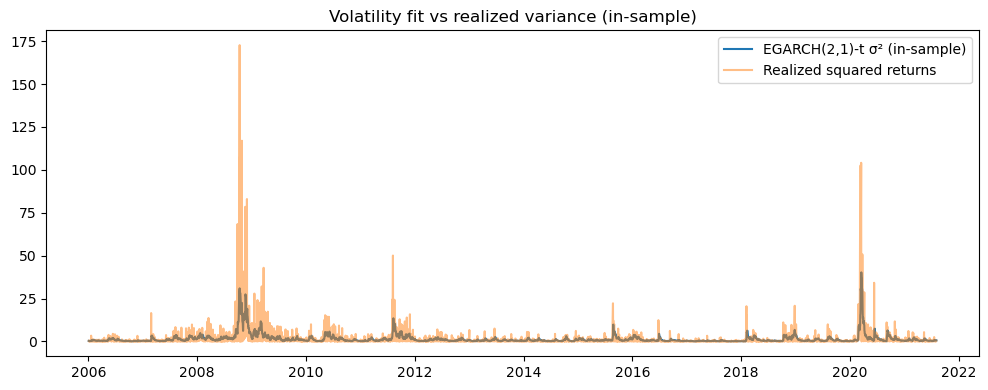

✅ Saved: data\processed\egarch_21_var_insample.csv data\processed\egarch_21_std_resid.csv data\processed\egarch_diagnostics_summary.csv


In [386]:
# ===== EGARCH(2,1)-t: Fit, in-sample variance, diagnostics, plot, save =====
# Assumes you already have: arimax_out (dict-like) with 'resid_tr' series

# 0) Imports
from arch import arch_model
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

# 1) Pull residuals used for variance modeling (training sample)
resid = arimax_out['resid_tr'].dropna()
assert isinstance(resid, pd.Series) and not resid.empty, "resid_tr must be a non-empty pandas Series."

# 2) Fit chosen model (EGARCH(2,1)-t)
eg = arch_model(resid, mean='Zero', vol='EGARCH', p=2, o=1, q=1, dist='t').fit(disp='off')

# 3) Report key params
params = eg.params
pvals  = eg.pvalues
gamma_name = next((n for n in params.index if 'gamma' in n), None)
gamma  = params.get(gamma_name, np.nan)
gamma_p= pvals.get(gamma_name, np.nan)
print(f"Chosen: EGARCH(2,1)-t | AIC={eg.aic:.2f}, BIC={eg.bic:.2f}, {gamma_name}={gamma:.4f}, p={gamma_p:.2g}")

# 4) Build IN-SAMPLE conditional variance series (σ_t^2) and realized variance (r_t^2)
cond_var = (eg.conditional_volatility ** 2).rename('egarch_var_in_sample')
real_var = (resid ** 2).rename('realized_sq_ret')
dfv = pd.concat([cond_var, real_var], axis=1).dropna()

# 5) Diagnostics on standardized residuals
std = eg.std_resid.dropna()
lb  = acorr_ljungbox(std, lags=[10, 20], return_df=True)['lb_pvalue']
arch_p = het_arch(std, nlags=12)[1]  # p-value
print(f"Ljung–Box p (10,20): {lb.iloc[0]:.6f}, {lb.iloc[1]:.6f}")
print(f"ARCH LM p (lag 12): {arch_p:.4g}")

# 6) Plot: EGARCH in-sample σ² vs realized squared returns
plt.figure(figsize=(10,4))
plt.plot(dfv.index, dfv['egarch_var_in_sample'], label='EGARCH(2,1)-t σ² (in-sample)')
plt.plot(dfv.index, dfv['realized_sq_ret'], alpha=0.5, label='Realized squared returns')
plt.title('Volatility fit vs realized variance (in-sample)')
plt.legend(); plt.tight_layout(); plt.show()

# 7) Save outputs for downstream LSTM features / appendix
OUTDIR = Path("data/processed"); OUTDIR.mkdir(parents=True, exist_ok=True)
dfv['egarch_var_in_sample'].to_csv(OUTDIR / "egarch_21_var_insample.csv")
std.rename('egarch_21_std_resid').to_csv(OUTDIR / "egarch_21_std_resid.csv")

# 8) (Optional) Save a diagnostics summary row for your report
diag = pd.DataFrame([{
    'model': 'EGARCH(2,1)-t',
    'AIC': eg.aic, 'BIC': eg.bic,
    gamma_name: gamma, f'{gamma_name}_p': gamma_p,
    'LB_p_lag10': float(lb.iloc[0]), 'LB_p_lag20': float(lb.iloc[1]),
    'ARCH_LM_p_lag12': float(arch_p)
}])
csv_path = OUTDIR / "egarch_diagnostics_summary.csv"
if csv_path.exists():
    diag.to_csv(csv_path, mode='a', header=False, index=False)
else:
    diag.to_csv(csv_path, index=False)

print("✅ Saved:",
      OUTDIR / "egarch_21_var_insample.csv",
      OUTDIR / "egarch_21_std_resid.csv",
      OUTDIR / "egarch_diagnostics_summary.csv")

# ARIMAX + EGARCH best-fit + forecast pipeline

In [389]:
#Setup and imports
# ============================================
# Setup & Imports for ARIMAX + EGARCH Pipeline
# ============================================

import warnings, itertools, numpy as np, pandas as pd
from pathlib import Path
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model

1. Prepare target and exogenous data

In [392]:
print(df.columns.tolist())

[('SPY_Close', 'SPY'), ('DXY_Close', 'DX-Y.NYB'), ('WTI_Close', 'CL=F'), ('SPY_log_ret', ''), ('SPY_price_change', ''), ('SPY_p_change', ''), ('DXY_ret', ''), ('WTI_ret', '')]


In [394]:
# ============================================
# Prepare target (S&P 500 returns) and exogenous regressors
# Handles MultiIndex columns
# ============================================

# Flatten MultiIndex columns if needed
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join([str(c) for c in col if c]).strip() for col in df.columns]

print("Flattened columns:", df.columns.tolist())

# Verify presence of expected columns
assert {'SPY_log_ret', 'DXY_ret', 'WTI_ret'}.issubset(df.columns), "Required columns missing."

# Define target and regressors
y = df['SPY_log_ret'].astype(float).copy()
X = df[['DXY_ret', 'WTI_ret']].astype(float).copy()

# Align and clean
y, X = y.align(X, join='inner')
y, X = y.dropna(), X.dropna()
y, X = y.align(X, join='inner')

print(f"✅ Final shapes → y: {y.shape},  X: {X.shape}")

Flattened columns: ['SPY_Close_SPY', 'DXY_Close_DX-Y.NYB', 'WTI_Close_CL=F', 'SPY_log_ret', 'SPY_price_change', 'SPY_p_change', 'DXY_ret', 'WTI_ret']
✅ Final shapes → y: (4895,),  X: (4895, 2)


2. Define ARIMAX Grid Search Function

In [397]:
# ============================================
# Function to fit ARIMAX(p,d,q) grid and rank by ICs
# ============================================

def fit_arimax_grid(y, X, ar=(0,1,2,3), d=(0,1), ma=(0,1,2,3)):
    out = []
    for p,d_,q in itertools.product(ar, d, ma):
        try:
            mod = SARIMAX(y, order=(p,d_,q), exog=X, trend='n',
                          enforce_stationarity=False, enforce_invertibility=False)
            res = mod.fit(disp=False)
            out.append({'p':p,'d':d_,'q':q,'bic':res.bic,'aic':res.aic,'llf':res.llf,'res':res})
        except Exception:
            continue
    if not out:
        raise RuntimeError("No ARIMAX candidate could be fit.")
    return sorted(out, key=lambda r: (r['bic'], r['aic']))

3. Select best ARIMAX model

In [400]:
# ============================================
# Select best ARIMAX model by BIC, then AIC
# ============================================

arimax_rank = fit_arimax_grid(y, X)
best_arimax = arimax_rank[0]

p, d_, q = best_arimax['p'], best_arimax['d'], best_arimax['q']
print(f"✅ Selected ARIMAX({p},{d_},{q})  |  BIC={best_arimax['bic']:.2f}, AIC={best_arimax['aic']:.2f}")

✅ Selected ARIMAX(0,0,1)  |  BIC=15377.61, AIC=15351.63


4. Select best EGARCH model

In [426]:
# ============================================
# Use previously validated EGARCH(2,1)-t model
# ============================================

ep, eo, eq, edist = 2, 1, 1, 't'
print(f"✅ Using fixed EGARCH({ep},{eo},{eq})-{edist} based on previous model diagnostics.")

✅ Using fixed EGARCH(2,1,1)-t based on previous model diagnostics.


5. Rolling Out-of-Sample Forecasts

In [431]:
# ===============================================================
# 5. Rolling 1-step-ahead forecasts (ARIMAX mean + EGARCH variance)
#    using selected ARIMAX(p,d,q) and fixed EGARCH(ep,eo,eq)-{edist}
# ===============================================================

from pathlib import Path
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model

# --- inputs expected from previous cells ---
# y : pd.Series (target, e.g. SPY_log_ret), Date index
# X : pd.DataFrame (exogenous regressors, aligned with y)
# p, d_, q : best ARIMAX orders from model selection
# ep, eo, eq, edist : fixed EGARCH configuration from diagnostics

START = int(len(y) * 0.70)          # expanding-window start (≈70% train)
OUTDIR = Path("data/processed")
OUTDIR.mkdir(parents=True, exist_ok=True)

mu_vals,  mu_idx  = [], []
var_vals, var_idx = [], []

# Optional: warm-start ARIMAX with previous iteration's params
last_params = None

for t in range(START, len(y)):
    # Expanding window up to (but not including) time t
    y_tr = y.iloc[:t]
    X_tr = X.iloc[:t]

    # Exogenous values at forecast time t (keep as 1-row DataFrame)
    X_fc = X.iloc[[t]]

    # -------- ARIMAX mean forecast (1-step) --------
    mod = SARIMAX(
        y_tr,
        order=(p, d_, q),
        exog=X_tr,
        trend='n',
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

    # Warm-start if we have previous params
    res = (
        mod.fit(disp=False, start_params=last_params)
        if last_params is not None
        else mod.fit(disp=False)
    )
    last_params = res.params.values  # cache for next iteration

    fc = res.get_forecast(steps=1, exog=X_fc)
    mu_hat = float(fc.predicted_mean.iloc[0])

    mu_vals.append(mu_hat)
    mu_idx.append(y.index[t])

    # -------- EGARCH variance forecast (1-step) on ARIMAX residuals --------
    resid_tr = res.resid.dropna()

    eg = arch_model(
        resid_tr,
        mean="Zero",
        vol="EGARCH",
        p=ep,
        o=eo,
        q=eq,
        dist=edist,
    ).fit(disp="off")

    var_hat = float(eg.forecast(horizon=1, reindex=True).variance.iloc[-1, 0])

    var_vals.append(var_hat)
    var_idx.append(y.index[t])

# -------- Build result series --------
mu_fc = pd.Series(mu_vals, index=pd.DatetimeIndex(mu_idx), name="arimax_mu_fc1")
var_fc = pd.Series(var_vals, index=pd.DatetimeIndex(var_idx), name="egarch_var_fc1")

# -------- Save artifacts --------
mu_path  = OUTDIR / "arimax_mu_fc1.csv"
var_path = OUTDIR / "egarch_var_fc1.csv"

mu_fc.to_csv(mu_path)
var_fc.to_csv(var_path)

print("✅ Saved rolling ARIMAX–EGARCH forecasts to:")
print("   ", mu_path)
print("   ", var_path)
print("Shapes -> mu_fc:", mu_fc.shape, "| var_fc:", var_fc.shape)

✅ Saved rolling ARIMAX–EGARCH forecasts to:
    data\processed\arimax_mu_fc1.csv
    data\processed\egarch_var_fc1.csv
Shapes -> mu_fc: (1469,) | var_fc: (1469,)


In [433]:
(mu_fc.index == var_fc.index).all()

True

6. Save Information Criteria Summary

In [436]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model

# 1) Fit ARIMAX(p,d,q) on the full sample to get residuals
mod_full = SARIMAX(
    y, order=(p, d_, q), exog=X, trend="n",
    enforce_stationarity=False, enforce_invertibility=False
)
res_full = mod_full.fit(disp=False)
resid_full = res_full.resid.dropna()

# 2) Fit fixed EGARCH(2,1,1)-t on those residuals
eg_full = arch_model(
    resid_full, mean="Zero", vol="EGARCH",
    p=ep, o=eo, q=eq, dist=edist
).fit(disp="off")

eg_bic = eg_full.bic
eg_aic = eg_full.aic
eg_llf = eg_full.loglikelihood

In [438]:
# ======================================================
# Save model selection summary for documentation
# ======================================================
import numpy as np
import pandas as pd

ic_tbl = pd.DataFrame([
    {
        "component": "mean",
        "model":     f"ARIMAX({p},{d_},{q})",
        "BIC":       best_arimax["bic"],
        "AIC":       best_arimax["aic"],
        "LLF":       best_arimax["llf"],
    },
    {
        "component": "vol",
        "model":     f"EGARCH({ep},{eo},{eq})-{edist}",
        # we didn't re-run an EGARCH IC grid in this notebook,
        # so leave these as NaN or fill manually if you have the numbers
        "BIC":       eg_bic,
        "AIC":       eg_aic,
        "LLF":       eg_llf,
    },
])

ic_tbl.to_csv(OUTDIR / "arimax_egarch_ic_summary.csv", index=False)
print("✅ Saved summary:", OUTDIR / "arimax_egarch_ic_summary.csv")
ic_tbl

✅ Saved summary: data\processed\arimax_egarch_ic_summary.csv


,component,model,BIC,AIC,LLF
0,mean,"ARIMAX(0,0,1)",15377.610969,15351.628725,-7671.814363
1,vol,"EGARCH(2,1,1)-t",12636.666183,12597.690365,-6292.845183


7. Diagnostic Plots

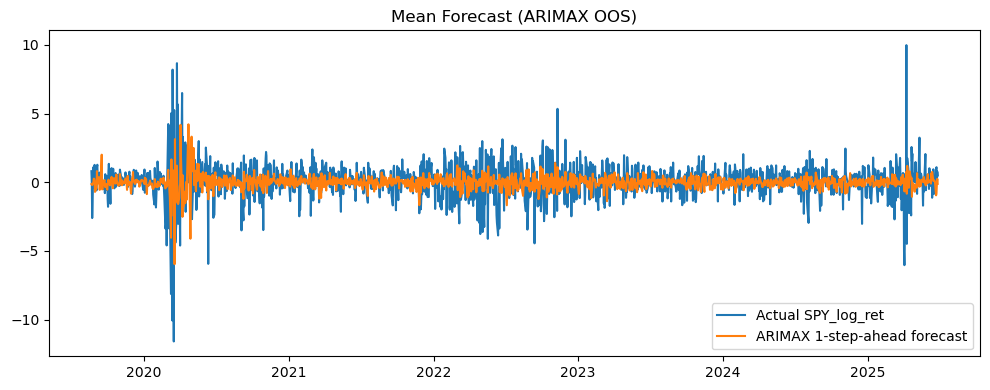

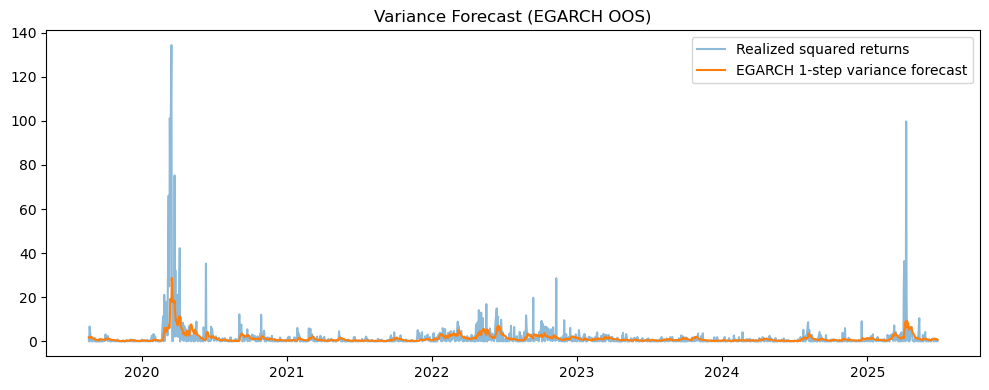

In [441]:
# ============================================
# Visualize forecasts vs actuals
# ============================================
import matplotlib.pyplot as plt

common = mu_fc.index.intersection(var_fc.index)

# Mean forecast
plt.figure(figsize=(10,4))
plt.plot(y.loc[common], label='Actual SPY_log_ret')
plt.plot(mu_fc.loc[common], label='ARIMAX 1-step-ahead forecast')
plt.legend(); plt.title('Mean Forecast (ARIMAX OOS)')
plt.tight_layout(); plt.show()

# Variance forecast
plt.figure(figsize=(10,4))
plt.plot((y.loc[common]**2), alpha=0.5, label='Realized squared returns')
plt.plot(var_fc.loc[common], label='EGARCH 1-step variance forecast')
plt.legend(); plt.title('Variance Forecast (EGARCH OOS)')
plt.tight_layout(); plt.show()

In [443]:
# ============================================================
# Evaluation: ARIMAX OOS Forecast Accuracy
# ============================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ensure alignment of actuals and forecasts
actual = y.loc[mu_fc.index]
forecast = mu_fc.reindex(actual.index)

# Compute metrics
rmse = np.sqrt(mean_squared_error(actual, forecast))
mae  = mean_absolute_error(actual, forecast)

# Optional variance forecast check
realized_var = (actual ** 2).reindex(var_fc.index)
var_rmse = np.sqrt(mean_squared_error(realized_var, var_fc))
var_mae  = mean_absolute_error(realized_var, var_fc)

# Display results
print("📈 ARIMAX Mean Forecast Evaluation")
print(f"RMSE (returns): {rmse:.4f}")
print(f"MAE  (returns): {mae:.4f}\n")

print("📊 EGARCH Variance Forecast Evaluation")
print(f"RMSE (variance): {var_rmse:.4f}")
print(f"MAE  (variance): {var_mae:.4f}")

# Save summary table
eval_tbl = pd.DataFrame({
    'Metric': ['RMSE', 'MAE'],
    'ARIMAX (Mean)': [rmse, mae],
    'EGARCH (Variance)': [var_rmse, var_mae]
})
eval_tbl.to_csv(OUTDIR / "arimax_egarch_eval_summary.csv", index=False)

print("\n✅ Saved:", OUTDIR / "arimax_egarch_eval_summary.csv")
eval_tbl

📈 ARIMAX Mean Forecast Evaluation
RMSE (returns): 1.2664
MAE  (returns): 0.8481

📊 EGARCH Variance Forecast Evaluation
RMSE (variance): 5.9690
MAE  (variance): 1.6489

✅ Saved: data\processed\arimax_egarch_eval_summary.csv


,Metric,ARIMAX (Mean),EGARCH (Variance)
0,RMSE,1.266446,5.969029
1,MAE,0.848140,1.648857


# Merge EGARCH Variance + Standardized Residual back into the main dataframe

In [450]:
# =============================================================
# Merge EGARCH variance + standardized residuals into AWT df
# =============================================================
from pathlib import Path
import pandas as pd

BASE = Path("data/processed")

# 1) Load main AWT + indicator dataframe
path_main = BASE / "df_awt_features.csv"   # adjust if named differently
df_main = (
    pd.read_csv(path_main, parse_dates=["Date"])
      .set_index("Date")
      .sort_index()
)
print("df_main shape:", df_main.shape)

# 2) Load EGARCH variance and standardized residuals
#    -> use the *rolling* forecast variance from Step 5
egarch_var = (
    pd.read_csv(BASE / "egarch_var_fc1.csv", index_col=0, parse_dates=True)
      .sort_index()
)
egarch_var.columns = ["var_fc_egarch"]
print("egarch_var shape:", egarch_var.shape)

egarch_resid = (
    pd.read_csv(BASE / "egarch_std_resid.csv", index_col=0, parse_dates=True)
      .sort_index()
)
egarch_resid.columns = ["egarch_std_resid"]
print("egarch_resid shape:", egarch_resid.shape)

# 3) Merge on the Date index
df_merged = (
    df_main
    .join(egarch_var, how="left")
    .join(egarch_resid, how="left")
)

# 4) Filter rows
before = df_merged.shape

# (a) always require target
mask = df_merged["y_1d"].notna()

# (b) Require EGARCH variance forecast (key feature)
mask &= df_merged["var_fc_egarch"].notna()

df_merged = df_merged[mask]
after = df_merged.shape
print(f"Shape before filter: {before}, after: {after}")

# 5) Quick sanity check of key columns
keep_cols = ["SPY_log_ret", "var_fc_egarch", "egarch_std_resid"]
print("\nHead (key cols):")
print(df_merged[keep_cols].head())

# 6) Save final feature set for LSTM
out_path = BASE / "final_features_preLSTM.csv"
df_merged.to_csv(out_path)
print("✅ Saved merged features to:", out_path.resolve())

df_main shape: (4901, 32)
egarch_var shape: (1469, 1)
egarch_resid shape: (3916, 1)
Shape before filter: (4901, 34), after: (1468, 34)

Head (key cols):
            SPY_log_ret  var_fc_egarch  egarch_std_resid
Date                                                    
2019-08-21     0.810224       1.907959          0.529980
2019-08-22    -0.030805       1.607498         -0.151105
2019-08-23    -2.602297       1.443746         -1.898114
2019-08-26     1.099767       2.088366          0.335562
2019-08-27    -0.393121       2.003276         -0.139841
✅ Saved merged features to: C:\Users\josep\Dropbox\My PC (DESKTOP-RVOVV0E)\Documents\Investment Analysis MSc\Research Project\Code Base\AWT-LSTM-ARIMAX-FIEGARCH-Model\data\processed\final_features_preLSTM.csv


# Feature selection for LSTM inputs

In [457]:
# ============================================
# 3.5 FEATURE SELECTION FOR LSTM INPUTS
# ============================================

import pandas as pd
import numpy as np
from pathlib import Path
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import acf

BASE = Path("data/processed")
df = pd.read_csv(BASE / "final_features_preLSTM.csv", parse_dates=["Date"], index_col="Date")

print("Loaded final pre-LSTM dataset:", df.shape)

# -------------------------------------------------------
# 1. TECHNICAL INDICATOR SELECTION (via XGBoost)
# -------------------------------------------------------

technical_cols = [
    c for c in df.columns
    if any(k in c.lower() for k in [
        "ema", "ma", "macd", "rsi", "sto", "adx", 
        "obv", "mfi", "will", "boll", "volume"
    ])
]

print("Technical indicator candidates:", len(technical_cols))

X_tech = df[technical_cols].fillna(0)
y_target = df["y_1d"]

# Train simple XGBoost model
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_tech, y_target)

# Feature importance ranking
importance = (
    pd.Series(xgb.feature_importances_, index=technical_cols)
      .sort_values(ascending=False)
)

TOP_K = 10
selected_technical = importance.head(TOP_K).index.tolist()

print("\nTop technical indicators selected:")
print(selected_technical)

# -------------------------------------------------------
# 2. LAG FEATURES (ACF-based)
# -------------------------------------------------------

returns = df["SPY_log_ret"].dropna()

# Compute ACF up to lag 20
acf_vals = acf(returns, nlags=20, fft=True)

# Select lags where autocorrelation > 0.05 (rule-of-thumb)
lag_candidates = [lag for lag, val in enumerate(acf_vals) if (lag > 0 and abs(val) > 0.05)]

# Restrict to first 10 lags
lag_candidates = lag_candidates[:10]

print("\nSelected ACF-based lags:", lag_candidates)

# Construct lag features
for lag in lag_candidates:
    df[f"lag_{lag}"] = df["SPY_log_ret"].shift(lag)

# -------------------------------------------------------
# 3. EXOGENOUS VARIABLES (direct)
# -------------------------------------------------------

exog_cols = []
if "DXY_ret" in df.columns:
    exog_cols.append("DXY_ret")
if "WTI_ret" in df.columns:
    exog_cols.append("WTI_ret")

print("\nExogenous variables included:", exog_cols)

# -------------------------------------------------------
# 4. ARIMAX–EGARCH MODEL OUTPUTS (from merged dataset)
# -------------------------------------------------------

model_cols = ["var_fc_egarch", "egarch_std_resid"]

model_cols = [c for c in model_cols if c in df.columns]

print("\nEconometric model input columns:", model_cols)

# -------------------------------------------------------
# FINAL FEATURE SET — assembled for LSTM
# -------------------------------------------------------

feature_cols = selected_technical + model_cols + exog_cols + [f"lag_{l}" for l in lag_candidates]

# Always include the key driver
feature_cols = ["SPY_log_ret"] + feature_cols

# Drop rows with missing target
df_lstm = df[feature_cols + ["y_1d"]].dropna()

print("\nFinal LSTM feature set:", df_lstm.shape)

df_lstm.to_csv(BASE / "lstm_feature_inputs.csv")
print("\nSaved LSTM inputs to:", (BASE / "lstm_feature_inputs.csv").resolve())

Loaded final pre-LSTM dataset: (1468, 34)
Technical indicator candidates: 15

Top technical indicators selected:
['RSI14', 'BOLL_lower', 'MACD', 'WILLR14', 'MA10', 'EMA20', 'MA5', 'STO_K', 'BOLL_bandwidth', 'Volume_SPY']

Selected ACF-based lags: [1, 2, 4, 5, 6, 7, 8, 9, 13, 14]

Exogenous variables included: ['DXY_ret', 'WTI_ret']

Econometric model input columns: ['var_fc_egarch', 'egarch_std_resid']

Final LSTM feature set: (476, 26)

Saved LSTM inputs to: C:\Users\josep\Dropbox\My PC (DESKTOP-RVOVV0E)\Documents\Investment Analysis MSc\Research Project\Code Base\AWT-LSTM-ARIMAX-FIEGARCH-Model\data\processed\lstm_feature_inputs.csv
